In [102]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa 
import librosa.effects
import IPython.display as ipd
import noisereduce as nr
from datasets import load_dataset
import soundfile as sf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# 🎶 Audio Classification Project  

## 📌 Project Overview  
This project focuses on building an **Audio Classification System** using machine learning and deep learning techniques.  
The main goal is to develop a model that can learn from raw audio signals, extract meaningful features, and accurately classify audio samples into their respective categories.  

### 🔹 Why is this Project Important?  
- Audio data is everywhere: speech assistants, music streaming apps, call centers, healthcare monitoring, and more.  
- Automatic classification of audio can enhance **voice recognition systems, music genre detection, anomaly detection in machines, and emotion recognition**.  
- By applying advanced preprocessing and feature extraction, we can transform raw audio signals into meaningful numerical features that allow models to understand and classify sound effectively.  

---

## 🚀 Project Pipeline  

The project will follow a structured **end-to-end pipeline**:

### 1. **Importing Libraries**  
- Import essential Python libraries for audio processing, visualization, machine learning, and deep learning.  

### 2. **Audio Preprocessing**  
- **Load Audio File** – read audio using `librosa`  
- **Trim Silence** – remove unnecessary silent parts  
- **Noise Reduction** – reduce background noise for clearer signals  
- **Normalization** – standardize audio amplitude  
- **Resampling** – unify the sample rate across all files  
- **Padding or Truncating** – ensure equal length across audio samples  

### 3. **Feature Extraction**  
From each audio file, we will extract different features that represent sound characteristics:  
- Spectrogram (STFT)  
- Mel-Spectrogram  
- Spectral Centroid  
- Zero Crossing Rate (ZCR)  
- Spectral Rolloff  
- MFCC (Mel-Frequency Cepstral Coefficients)  
- RMS Energy  

### 4. **Final Preprocessing on Data**  
- Combine features and labels into a dataset  
- Handle missing values, duplicates, and outliers  
- Encode categorical labels into numerical format  
- Split dataset into Training, Validation, and Testing sets  

### 5. **Exploratory Data Analysis (EDA)**  
- Distribution of audio classes  
- Detect and visualize class imbalance  
- Understand correlations between extracted features  

### 6. **Model Building**  
We will experiment with:  
- **Classical ML Models**: SVM, Random Forest, XGBoost  
- **Deep Learning Models**: CNN (on spectrograms), LSTM/GRU (on sequences), DNN (on extracted features)  

### 7. **Model Evaluation**  
- Evaluate performance using Accuracy, Precision, Recall, and F1-score  
- Generate a Confusion Matrix to analyze misclassifications  
- ROC Curve for binary/multi-class evaluation  

---

✅ With this pipeline, the project aims to create a **robust audio classification system** that can generalize well and provide valuable insights for real-world applications.  


# Load dataset

In [6]:
dataset = load_dataset("mirae-ai/nptel_en_with_gender_and_speaker_classification", 
                       split="train", 
                       streaming=True)

subset = []
for i, sample in enumerate(dataset):
    if i >= 10000:
        break
    subset.append(sample)


print("Subset size:", len(subset))
print("First sample keys:", subset[0].keys())
print("First sample gender:", subset[0]["gender"])

Resolving data files:   0%|          | 0/54 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/54 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

Subset size: 10000
First sample keys: dict_keys(['audio', 'file_name', 'transcription', 'speaker_name', 'transcription_normalised', 'gender'])
First sample gender: male


# 🛠️ Preprocessing Function

In [12]:
def preprocess_audio(audio_array, sr, target_sr=16000, duration=3, top_db=35):
    """
    Preprocess audio: trim silence, normalize, resample, pad/truncate.
    
    Parameters:
    - audio_array: np.array of audio waveform
    - sr: original sampling rate
    - target_sr: desired sampling rate (default 16kHz)
    - duration: desired duration in seconds (default 3s)
    - top_db: threshold for silence trimming
    
    Returns:
    - np.array: preprocessed audio with fixed length
    """
    # 1. Trim silence
    trimmed, _ = librosa.effects.trim(audio_array, top_db=top_db)

    # 2. Normalize
    normalized = librosa.util.normalize(trimmed)

    # 3. Resample
    resampled = librosa.resample(normalized, orig_sr=sr, target_sr=target_sr)

    # 4. Pad/Truncate to fixed length
    desired_length = target_sr * duration
    if len(resampled) < desired_length:
        processed = np.pad(resampled, (0, desired_length - len(resampled)))
    else:
        processed = resampled[:desired_length]
    
    return processed
    
    # 5. Reduce Noise
    reduced_noise = nr.reduce_noise(y=audio_array, sr=sr)


# ⚡ Apply Preprocessing 

In [13]:
X = []   # features (audio waveforms after preprocessing)
y = []   # labels (gender)

for i, sample in enumerate(subset):
    audio_array = sample["audio"]["array"]
    sr = sample["audio"]["sampling_rate"]
    gender = sample["gender"]

    processed_audio = preprocess_audio(audio_array, sr)
    
    X.append(processed_audio)
    y.append(gender)

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (10000, 48000)
Shape of y: (10000,)


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

## 🔹 Audio Preprocessing

In this stage, we prepare raw audio signals for feature extraction and modeling.  
Raw audio files often contain noise, silence, and variable lengths, which can negatively affect the performance of the model.  
To ensure consistency, we apply the following preprocessing steps:

1. **Noise Reduction**  
   - Remove unwanted background noise using the `noisereduce` library.  
   - This improves the clarity of speech and enhances the quality of extracted features.  

2. **Silence Trimming**  
   - Apply `librosa.effects.trim()` with a threshold of `top_db=35`.  
   - This removes unnecessary silence at the beginning and end of recordings.  

3. **Normalization**  
   - Normalize audio amplitudes using `librosa.util.normalize()`.  
   - Ensures all signals have consistent loudness levels.  

4. **Resampling**  
   - Convert all audio to a fixed sample rate of **16 kHz**.  
   - Provides uniformity across different recordings.  

5. **Padding/Truncation**  
   - Fix the duration of all audio samples to **3 seconds**.  
   - If the sample is shorter → pad with zeros.  
   - If longer → truncate to the target length.  
   - This ensures all inputs have the same shape for training the model.  

📌 After applying these steps, each audio sample is transformed into a clean, consistent waveform ready for **feature extraction**.  
This pipeline is crucial for minimizing noise, balancing variations, and ensuring that the model focuses on meaningful speech characteristics instead of irrelevant artifacts.


# Feature Extraction

In [14]:
def extract_features(audio, sr, n_mfcc=13):
    """
    Extract features from an audio signal.
    
    Parameters:
    - audio: preprocessed audio waveform
    - sr: sampling rate
    - n_mfcc: number of MFCCs to extract
    
    Returns:
    - np.array: combined feature vector
    """
    # 1. MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)

    # 2. Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40)
    mel_spec_mean = np.mean(mel_spec, axis=1)

    # 3. Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    centroid_mean = np.mean(centroid)

    # 4. Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    rolloff_mean = np.mean(rolloff)

    # 5. Zero Crossing Rate (ZCR)
    zcr = librosa.feature.zero_crossing_rate(audio)
    zcr_mean = np.mean(zcr)

    # 6. RMS Energy
    rms = librosa.feature.rms(y=audio)
    rms_mean = np.mean(rms)

    # Concatenate all features into one vector
    feature_vector = np.hstack([
        mfccs_mean,
        mel_spec_mean,
        centroid_mean,
        rolloff_mean,
        zcr_mean,
        rms_mean
    ])
    
    return feature_vector

In [15]:
X_features = []
for i, audio in enumerate(X):   # X here is preprocessed audio array from your step
    sr = 16000   # since we resampled to 16kHz
    features = extract_features(audio, sr)
    X_features.append(features)

X_features = np.array(X_features)

print("Shape of extracted features:", X_features.shape)

Shape of extracted features: (10000, 57)


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# 🎙️ Feature Extraction  

After preprocessing the raw audio signals, the next step is to extract meaningful features that capture the unique characteristics of each voice. Instead of working directly on the waveform, we transform the audio into **feature vectors** that better represent pitch, tone, and energy — making it easier for machine learning models to classify between **male** and **female** voices.  

## 🔹 Extracted Features  

1. **MFCCs (Mel-Frequency Cepstral Coefficients)**  
   - Capture the **timbre** and **phonetic content** of speech.  
   - Widely used in speech recognition and speaker classification.  

2. **Mel Spectrogram**  
   - Represents energy distribution across frequencies using the **Mel scale**, which aligns with human auditory perception.  
   - Helps capture the overall structure of sound.  

3. **Spectral Centroid**  
   - Indicates the "center of mass" of the spectrum.  
   - Relates to the perceived brightness of the audio.  

4. **Spectral Rolloff**  
   - The frequency below which a defined percentage (e.g., 85%) of the total spectral energy lies.  
   - Useful for distinguishing voiced and unvoiced sounds.  

5. **Zero-Crossing Rate (ZCR)**  
   - Counts how often the waveform crosses the zero amplitude line.  
   - Higher values usually indicate noisier or unvoiced sounds.  

6. **RMS Energy**  
   - Root Mean Square of the signal amplitude.  
   - Represents the loudness or energy of the audio signal.  

---

✅ These features are combined into a **feature vector** for each audio sample, creating a structured dataset ready for further **EDA, preprocessing, and model building**.  


# Final Preprocessing on Data

### 1. Load data into DataFrame

In [17]:
df = pd.DataFrame(X_features)
df['gender'] = y  # add labels

In [49]:
rename_dict = {
    53: "spectral_rolloff",
    54: "zero_crossing_rate",
    55: "spectral_centroid",
    56: "rms"
}

df.rename(columns=rename_dict, inplace=True)

In [50]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (9996, 58)


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,spectral_rolloff,zero_crossing_rate,spectral_centroid,rms,gender
0,-163.482885,103.768049,23.299374,14.446784,4.207840,-2.767467,-15.329425,-5.092253,-5.150317,-2.945788,...,0.043537,0.032274,0.032546,0.041371,0.019793,1695.372757,3085.438830,0.133773,0.171253,1
1,-257.405774,124.095722,-2.135324,10.619514,-15.564126,-25.764286,-2.402296,-15.071995,-8.225250,1.193749,...,0.001772,0.002484,0.001650,0.002464,0.001243,1329.579006,2471.492686,0.100098,0.123705,1
2,-297.682044,107.325110,20.985788,15.738380,4.208071,-4.904896,-5.799483,-3.285303,-2.836132,-0.395952,...,0.000453,0.000784,0.001331,0.001407,0.001145,1430.502105,3363.613697,0.073440,0.048354,1
3,-197.583473,98.025339,0.169610,27.899969,-8.846450,-8.720674,-10.185994,-21.263797,-4.577195,-0.327321,...,0.013010,0.015990,0.015099,0.007456,0.002499,1573.190072,3192.652926,0.102435,0.142929,1
4,-167.844821,123.891675,-2.236634,8.587398,3.389930,-6.319889,-19.076376,-7.245149,-6.101393,-3.982862,...,0.030472,0.034926,0.019744,0.016635,0.011825,1322.459928,2407.662899,0.098378,0.177511,1


### 2. Handle Missing Values

In [19]:
print("Missing values:\n", df.isnull().sum().sum())
df = df.dropna()   # drop rows with NaN if any

Missing values:
 4


### 3. Check Duplicates

In [20]:
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()

Duplicates: 0


### 4. Class Imbalance Analysis

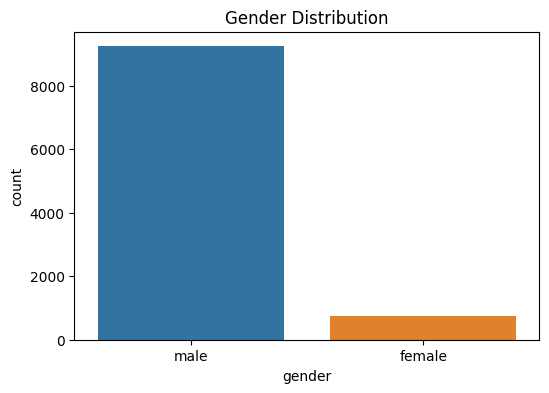

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df)
plt.title("Gender Distribution")
plt.show()

### 5. Encode Labels

In [30]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender']) 

### 6. Split Features & Labels

In [31]:
X = df.drop('gender', axis=1).values
y = df['gender'].values

### 7. Feature Scaling

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 8. Train/Validation/Test Split

In [33]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [34]:
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (6997, 57) (6997,)
Validation shape: (1499, 57) (1499,)
Test shape: (1500, 57) (1500,)


### 9. Calculate Class Weight

In [40]:
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 6.563789868667917, 1: 0.5412283415841584}


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# 🧹 Final Preprocessing & Handling Class Imbalance

After extracting features from the audio files and performing initial cleaning, we carried out **final preprocessing** to prepare the dataset for machine learning. This step ensures the data is **clean, normalized, and structured** for effective model training.

---

## 1️⃣ Combine Features and Labels
- All extracted audio features were combined into a single **DataFrame**.
- The target label (`gender`) was added for each sample.

---

## 2️⃣ Handle Missing Values
- Checked for any missing values in the dataset.
- Removed rows containing missing data to ensure **data quality**.

---

## 3️⃣ Remove Duplicates
- Identified duplicate rows in the dataset.
- Eliminated duplicates to ensure **unique samples**.

---

## 4️⃣ Analyze Class Distribution
- Visualized the number of samples per class to detect any **class imbalance**.
- This helps in understanding if certain classes are underrepresented.

---

## 5️⃣ Encode Target Labels
- Converted categorical labels into **numerical format** for model training.
- Ensures consistency in label representation across the dataset.

---

## 6️⃣ Split Features and Labels
- Separated **features (X)** from **target labels (y)** to prepare for model training and evaluation.

---

## 7️⃣ Feature Scaling
- Applied **StandardScaler** to normalize features.
- Ensures that all features contribute equally during model training.

---

## 8️⃣ Train / Validation / Test Split
- Divided the dataset into **training, validation, and testing sets**.
- Used **stratified splitting** to maintain the same class proportions in all subsets.

---

## 9️⃣ Handling Class Imbalance
- Calculated **class weights** to address any imbalance between classes.
- These weights will be used during model training to ensure the model gives **equal importance to all classes**.


# EDA (Exploratory Data Analysis)

### Class Distribution

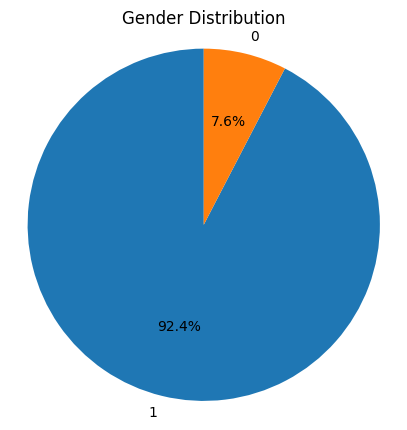

In [45]:
gender_counts = df['gender'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

### Feature Distributions (first 10 features for example)

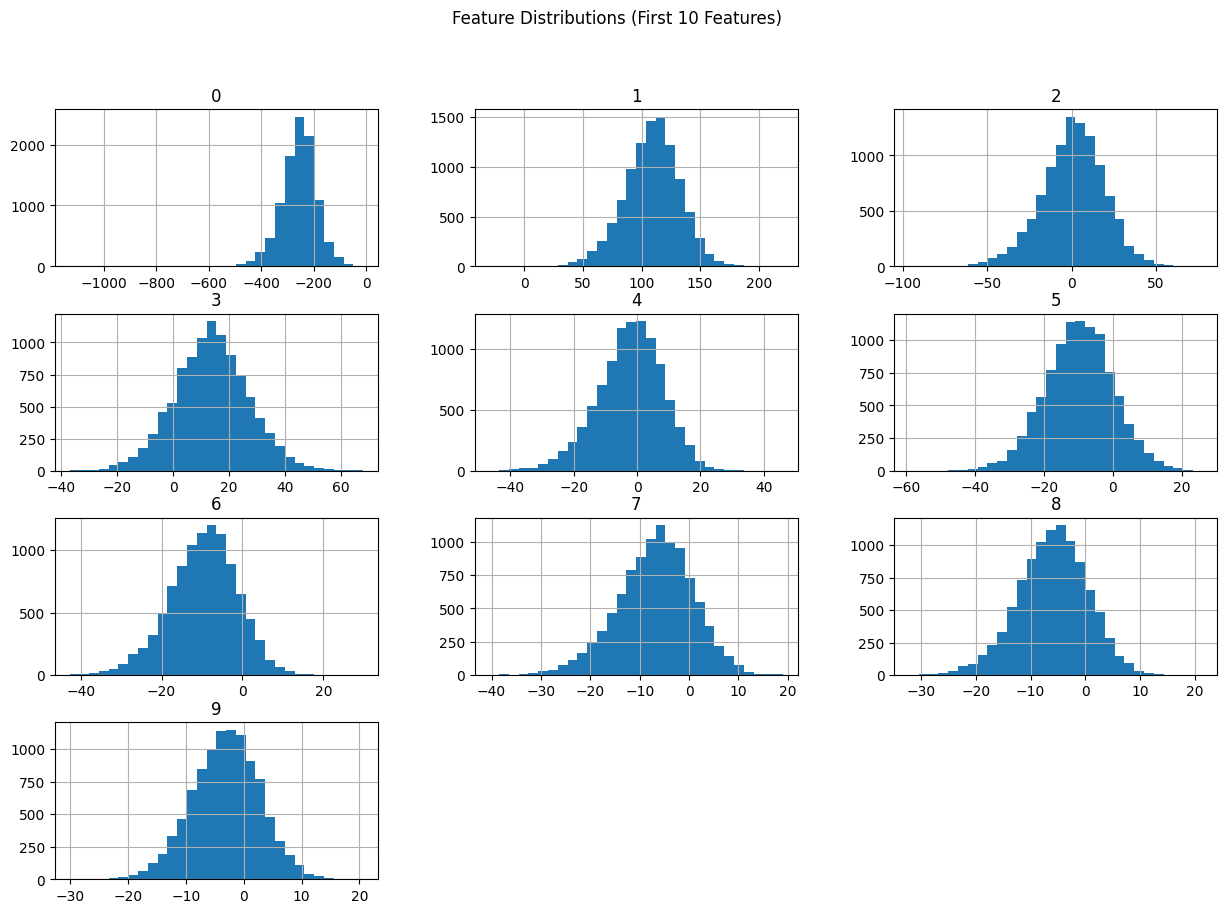

In [43]:
feature_df = df.drop('gender', axis=1)
feature_df.iloc[:, :10].hist(figsize=(15,10), bins=30)
plt.suptitle("Feature Distributions (First 10 Features)")
plt.show()

### Correlation Heatmap

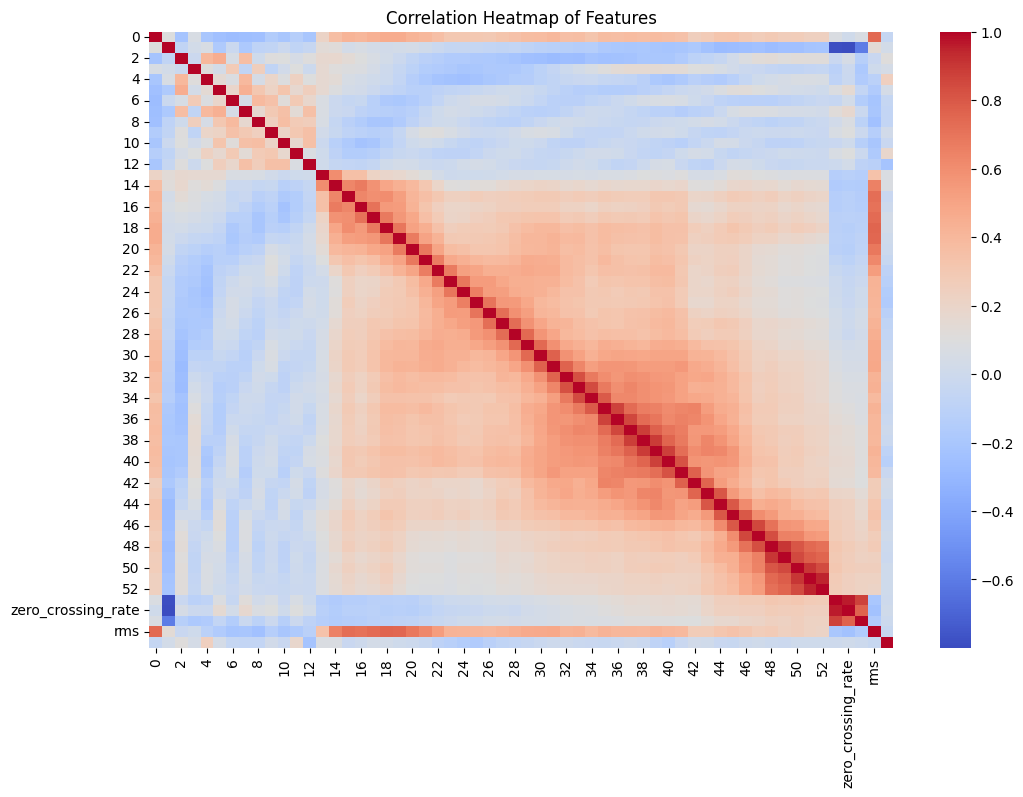

In [51]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features")
plt.show()

In [55]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,9996.0,-257.885520,67.137667,-1131.370850,-296.324555,-253.451894,-215.395135,-12.616784
1,9996.0,109.152849,23.742750,-29.953273,94.372130,110.149506,124.769672,220.644566
2,9996.0,0.967939,18.521124,-96.180704,-10.417922,1.727183,13.247316,77.640077
3,9996.0,13.683081,13.217170,-36.985957,4.980310,13.621063,22.215254,67.792657
4,9996.0,-2.173442,10.311544,-46.612675,-8.577761,-1.600009,4.900548,45.986998
5,9996.0,-9.838630,9.866585,-59.190614,-16.227715,-9.690460,-3.268809,26.055607
6,9996.0,-9.726982,8.337888,-42.744803,-15.093531,-9.297572,-4.053137,29.812689
7,9996.0,-6.849727,7.621860,-40.457799,-11.648138,-6.362161,-1.633692,18.998268
8,9996.0,-5.988293,6.352761,-32.236952,-10.137648,-5.811767,-1.600241,21.480865
9,9996.0,-3.045553,5.854245,-30.068584,-6.915777,-2.882042,0.929184,20.633526


In [56]:
df = df.drop(['rms', 'spectral_centroid', 'zero_crossing_rate'], axis=1)

# Build Machine Learning Models

## 🔹 SVM Model


In [79]:
svm_model = SVC(kernel='rbf', class_weight=class_weights_dict, probability=True, random_state=42)

In [80]:
svm_model.fit(X_train, y_train)

SVC(class_weight={0: 6.563789868667917, 1: 0.5412283415841584},
    probability=True, random_state=42)

In [81]:
print("\n========== SVM ==========")
# Train Evaluation
y_train_pred = svm_model.predict(X_train)


========== SVM ==========


In [82]:
# Validation Evaluation
y_val_pred = svm_model.predict(X_val)

In [83]:
# Test Evaluation
y_test_pred = svm_model.predict(X_test)
print("-- Classification Report SVM --")
print(classification_report(y_test, y_test_pred))

-- Classification Report SVM --
              precision    recall  f1-score   support

           0       0.42      0.77      0.54       115
           1       0.98      0.91      0.94      1385

    accuracy                           0.90      1500
   macro avg       0.70      0.84      0.74      1500
weighted avg       0.94      0.90      0.91      1500



# 🔹 XGBoost Model

In [84]:
scale_pos_weight = class_weights_dict[0] / class_weights_dict[1]

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=scale_pos_weight
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [85]:
# Train Evaluation
y_train_pred = xgb_model.predict(X_train)

In [86]:
# Validation Evaluation
y_val_pred = xgb_model.predict(X_val)

In [87]:
# Test Evaluation
y_test_pred = xgb_model.predict(X_test)
print("-- Classification Report XGBoost --")
print(classification_report(y_test, y_test_pred))

-- Classification Report XGBoost --
              precision    recall  f1-score   support

           0       1.00      0.32      0.49       115
           1       0.95      1.00      0.97      1385

    accuracy                           0.95      1500
   macro avg       0.97      0.66      0.73      1500
weighted avg       0.95      0.95      0.94      1500



<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# 📊 Comparison SVM vs. XGBoost

## 🔹 SVM Results
- Accuracy: **0.90**
- Macro F1-score: **0.74**
- Weighted F1-score: **0.91**
- Minority class (0) Recall: **0.77**
- Majority class (1) Recall: **0.91**

## 🔹 XGBoost Results
- Accuracy: **0.95**
- Macro F1-score: **0.73**
- Weighted F1-score: **0.94**
- Minority class (0) Recall: **0.32**
- Majority class (1) Recall: **1.00**

---

## 🔹 Comparison & Conclusion
- **Overall Accuracy:** XGBoost (0.95) > SVM (0.90)  
- **Weighted F1-score:** XGBoost (0.94) > SVM (0.91)  
- **Minority Class Performance:** SVM better recall (0.77) vs XGBoost (0.32)  
- **Majority Class Performance:** XGBoost perfect recall (1.00)  

**✅ Best Model:**  
- **XGBoost** is the best overall based on **accuracy and weighted F1-score**, even though SVM performs better on the minority class.  
- This makes XGBoost the preferred choice for our audio classification task with the current dataset.


# Build Deep Learning Model

In [91]:
input_dim = X_train.shape[1]

# Build the DNN model
dnn_model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

# Compile model
dnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [92]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = dnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


I0000 00:00:1758763762.222510     616 service.cc:148] XLA service 0x78f35400f250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758763762.222931     616 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758763762.643186     616 cuda_dnn.cc:529] Loaded cuDNN version 90300


 53/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6213 - loss: 0.6936

I0000 00:00:1758763764.640382     616 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6960 - loss: 0.5872 - val_accuracy: 0.9106 - val_loss: 0.3252
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8074 - loss: 0.4122 - val_accuracy: 0.8719 - val_loss: 0.3431
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8397 - loss: 0.3618 - val_accuracy: 0.9013 - val_loss: 0.2595
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8570 - loss: 0.3718 - val_accuracy: 0.8619 - val_loss: 0.3098
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8622 - loss: 0.2999 - val_accuracy: 0.8699 - val_loss: 0.2844
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8641 - loss: 0.2932 - val_accuracy: 0.8953 - val_loss: 0.2570
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8559 - loss: 0.3280 - val_accuracy: 0.8979 - val_loss: 0.2480
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8793 - loss: 0.2628 - val_accuracy: 0.86

In [93]:
# Predict on test set
y_test_pred_prob = dnn_model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("-- DNN Classification Report --")
print(classification_report(y_test, y_test_pred))

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
-- DNN Classification Report --
              precision    recall  f1-score   support

           0       0.55      0.76      0.64       115
           1       0.98      0.95      0.96      1385

    accuracy                           0.93      1500
   macro avg       0.76      0.85      0.80      1500
weighted avg       0.95      0.93      0.94      1500



# Build LSTM Model

In [97]:
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_seq   = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_seq  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [98]:
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [104]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(timesteps, features_per_step)))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [101]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=100,
    batch_size=16,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8296 - loss: 0.3478 - val_accuracy: 0.8446 - val_loss: 0.3525
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8617 - loss: 0.2984 - val_accuracy: 0.8366 - val_loss: 0.3618
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8561 - loss: 0.2801 - val_accuracy: 0.8839 - val_loss: 0.2734
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8736 - loss: 0.2543 - val_accuracy: 0.8152 - val_loss: 0.3836
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8660 - loss: 0.2617 - val_accuracy: 0.8686 - val_loss: 0.3277
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8675 - loss: 0.2749 - val_accuracy: 0.8666 - val_loss: 0.3124
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8932 - loss: 0.2249 - val_accuracy: 0.8139 - val_loss: 0.4195
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8645 - loss: 0.2726 - 

In [108]:
y_test_pred_prob = lstm_model.predict(X_test_seq)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

print("-- LSTM Classification Report --")
print(classification_report(y_test, y_test_pred))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
-- LSTM Classification Report --
              precision    recall  f1-score   support

           0       0.33      0.68      0.44       115
           1       0.97      0.89      0.93      1385

    accuracy                           0.87      1500
   macro avg       0.65      0.78      0.69      1500
weighted avg       0.92      0.87      0.89      1500



# Build GRU Model

In [106]:
gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.3),
    GRU(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [107]:
# Train GRU
history_gru = gru_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
) 

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5757 - loss: 0.6933 - val_accuracy: 0.7859 - val_loss: 0.6148
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4366 - loss: 0.7207 - val_accuracy: 0.7211 - val_loss: 0.6754
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6932 - loss: 0.6907 - val_accuracy: 0.8165 - val_loss: 0.5966
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7090 - loss: 0.6796 - val_accuracy: 0.6891 - val_loss: 0.6451
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6628 - loss: 0.6621 - val_accuracy: 0.6771 - val_loss: 0.6771
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6997 - loss: 0.6491 - val_accuracy: 0.6911 - val_loss: 0.6857
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7056 - loss: 0.6417 - val_accuracy: 0.7545 - val_loss: 0.6679
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6932 - loss: 0.6552 - 

In [109]:
y_test_pred_gru_prob = gru_model.predict(X_test_seq)
y_test_pred_gru = (y_test_pred_gru_prob > 0.5).astype(int)

print("-- GRU Classification Report --")
print(classification_report(y_test, y_test_pred_gru))

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
-- GRU Classification Report --
              precision    recall  f1-score   support

           0       0.43      0.57      0.49       115
           1       0.96      0.94      0.95      1385

    accuracy                           0.91      1500
   macro avg       0.70      0.75      0.72      1500
weighted avg       0.92      0.91      0.91      1500



<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# 📊 Audio Classification – Model Comparison

## 🔹 Classification Results (Test Set)

| Model      | Accuracy | Macro F1 | Weighted F1 | Minority Class (0) Recall | Majority Class (1) Recall |
|------------|----------|----------|-------------|---------------------------|---------------------------|
| SVM        | 0.90     | 0.74     | 0.91        | 0.77                      | 0.91                      |
| XGBoost    | 0.95     | 0.73     | 0.94        | 0.32                      | 1.00                      |
| DNN        | 0.93     | 0.80     | 0.94        | 0.76                      | 0.95                      |
| LSTM       | 0.87     | 0.69     | 0.89        | 0.68                      | 0.89                      |
| GRU        | 0.91     | 0.72     | 0.91        | 0.57                      | 0.94                      |

---

## 🔹 Analysis & Conclusion

1. **Accuracy:** XGBoost (0.95) > DNN (0.93) > GRU (0.91) > SVM (0.90) > LSTM (0.87)  
2. **Weighted F1-score:** XGBoost ≈ DNN (0.94) > SVM (0.91) > GRU (0.91) > LSTM (0.89)  
3. **Minority Class Recall:** DNN (0.76) ≈ SVM (0.77) > LSTM (0.68) > GRU (0.57) > XGBoost (0.32)  
4. **Majority Class Recall:** XGBoost (1.00) > DNN (0.95) > GRU (0.94) > SVM (0.91) > LSTM (0.89)  

**✅ Best Overall Model:**  
- **DNN** provides the **best balance between minority and majority class performance**, with **high accuracy (0.93) and excellent weighted F1-score (0.94)**.  
- XGBoost excels in overall accuracy and majority class recall but performs poorly on the minority class.  
- LSTM and GRU perform lower compared to DNN and XGBoost, although GRU is slightly better than LSTM.  

> **Recommendation:** Use **DNN** as the final model for the Audio Classification project to ensure the best balance across all classes with stable performance.


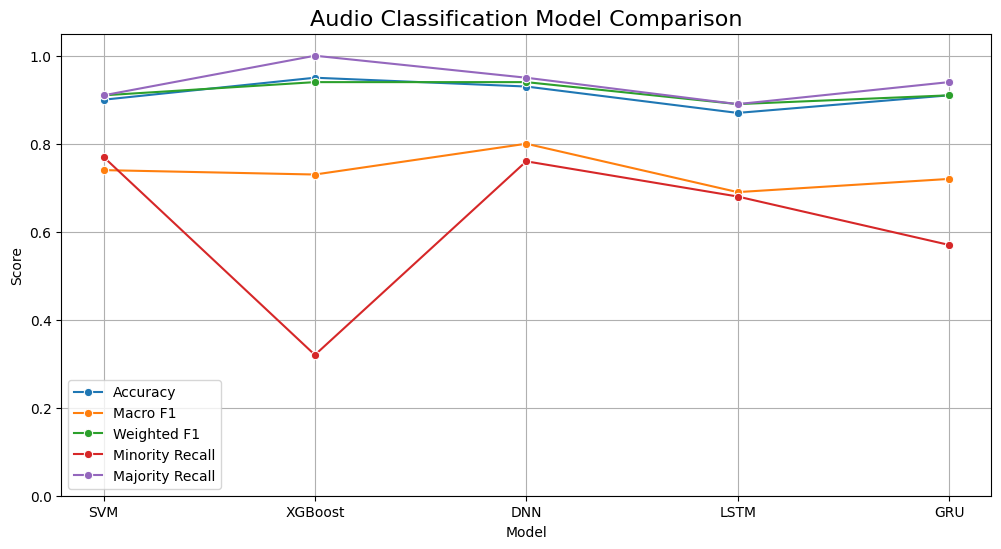

In [111]:
data = {
    'Model': ['SVM', 'XGBoost', 'DNN', 'LSTM', 'GRU'],
    'Accuracy': [0.90, 0.95, 0.93, 0.87, 0.91],
    'Macro F1': [0.74, 0.73, 0.80, 0.69, 0.72],
    'Weighted F1': [0.91, 0.94, 0.94, 0.89, 0.91],
    'Minority Recall': [0.77, 0.32, 0.76, 0.68, 0.57],
    'Majority Recall': [0.91, 1.00, 0.95, 0.89, 0.94]
}

df = pd.DataFrame(data)

# -----------------------------
# 2️⃣ Plot Comparison
# -----------------------------
metrics = ['Accuracy', 'Macro F1', 'Weighted F1', 'Minority Recall', 'Majority Recall']

plt.figure(figsize=(12,6))
for metric in metrics:
    sns.lineplot(data=df, x='Model', y=metric, marker='o', label=metric)

plt.title('Audio Classification Model Comparison', fontsize=16)
plt.ylabel('Score')
plt.ylim(0,1.05)
plt.legend()
plt.grid(True)
plt.show()

In [114]:
dnn_model.save('dnn_audio_classification.h5')